## Predicting total energies and enthalpies of formation of metal-nonmetal compounds by linear regression 

Here, we want to study the accuracy and time used to predict variable dataset sizes using the featurizations and algorithms used in [Deml et al paper](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.93.085142)

Referred to `matminer_examples/notebooks/machine-learning/predicting-formation-enthalpy-from-composition.ipynb `

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pymatgen as pmg
import matplotlib.pyplot as plt
import itertools

from mdf_forge.forge import Forge

from matminer.data_retrieval.retrieve_MDF import MDFDataRetrieval
from matminer.utils.conversions import str_to_composition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf

from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict, KFold
from sklearn import metrics

from matplotlib.colors import LogNorm

from pymatgen import MPRester

### Loading deml_dataset.csv 

In [2]:
csv_path = os.path.join(os.getcwd(), "deml_dataset.csv")
df = pd.read_csv(csv_path, comment='#')

### Part 1: Compute data representation

Compute pymatgen composition from compound formula

In [3]:
df['composition_obj'] = str_to_composition(df['composition'])

Compute ionic states

In [4]:
def get_oxidation_states(composition, tolerance=1e-6, common_states=False):
    """Given a composition, estimate what the likely ionic states are
    
    For systems where multiple it is possible to form multiple charge-neutral
    oxidation states, returns the one with the fewests occurances of 
    elements with higher electronegativities having more positive charges
    
    :param composition: Composition, composition to be estimated
    :param tolerance: float, tolerance for "zero" net charge
    :param common_states: bool, whether to use only common oxidation states
    :param max_states: bool, if there are more than these
    :return: dict, keys are elements, values are most likely state. 
        `None` if no possible charge balanced compound"""
    
    # Get the list of elements and their fractions
    elems,fracs = zip(*list(composition.fractional_composition.items()))
    
    # Compute all possible oxidation states
    possible_states = []
    oxidation_states = [e.common_oxidation_states if common_states else e.oxidation_states for e in elems]
    for states in itertools.product(*oxidation_states):
        charge = np.dot(states, fracs)
        if abs(charge) < tolerance:
            possible_states.append(states)
    
    # If <2 charge states, return answer
    if len(possible_states) == 0:
        return None
    elif len(possible_states) == 1:
        return dict(zip(elems,possible_states[0]))
    
    # If >=2 states, rank them by the fewest number of 
    #   pairs of atoms where the charge_A > charge_B yet
    #   X_A < X_B
    en = [e.X for e in elems]
    
    #   Function for scoring charge states
    def get_score(charges):
        score = 0
        for a,b in itertools.combinations(range(len(charges)), 2):
            if (charges[a] > charges[b]) == (en[a] > en[b]):
                score += 1
        return score
    scores = [get_score(x) for x in possible_states]
    
    # Get the "best" one
    sorted_states = sorted(zip(possible_states, scores), key=lambda x: x[1])[0]
    return dict(zip(elems, sorted_states[0]))
        
assert get_oxidation_states(pmg.Composition('NaCl')) == {pmg.Element('Na'):1, pmg.Element('Cl'):-1}
assert get_oxidation_states(pmg.Composition('H2O')) == {pmg.Element('H'):1, pmg.Element('O'):-2}
assert get_oxidation_states(pmg.Composition('Na2Cl'), common_states=False) == {pmg.Element('Na'):-1, pmg.Element('Cl'):2}
assert get_oxidation_states(pmg.Composition('Na2Cl'), common_states=True) == None

In [5]:
%%time
df['oxidation_states'] = df['composition_obj'].apply(lambda x: get_oxidation_states(x, common_states=True))

CPU times: user 121 ms, sys: 11.4 ms, total: 132 ms
Wall time: 125 ms


Compute total energy of a composition

In [9]:
df['total_energy'] = ''

(2338, 5)

In [10]:
%%time
mp = MPRester('ubX07DfzKy3mZAlw')
for i in range(df.shape[0]):
    e = mp.get_data(df['composition'][i], prop='energy')
    if (e == []):
        df['total_energy'][i] = np.nan
    else: 
        df['total_energy'][i] = e[0]['energy']

## TODO: USE QMPY TO CALCULATE TOTAL ENERGY INSTEAD

CPU times: user 43.1 s, sys: 2.7 s, total: 45.8 s
Wall time: 14min 17s


Adding a finite list of quantitative descriptors ([Deml et al 2016](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.93.085142))

In [11]:
%%time
ft = MultipleFeaturizer([cf.ElementProperty.from_preset('deml'), 
                         cf.TMetalFraction(),
                         cf.ValenceOrbital()])
df = ft.featurize_dataframe(df, col_id='composition_obj')

CPU times: user 922 ms, sys: 132 ms, total: 1.05 s
Wall time: 3.65 s


In [12]:
print ("Shape of featurized data: ", df.shape)
df.head(1)

Shape of featurized data:  (2338, 94)


,composition,delta_e,composition_obj,oxidation_states,total_energy,minimum atom_num,maximum atom_num,range atom_num,mean atom_num,std_dev atom_num,...,std_dev FERE correction,transition metal fraction,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
0,As1Y1,-1.555732,"(As, Y)","{As: -3, Y: 3}",-13.2544,33,39,6,36.0,4.242641,...,0.761822,0.0,2.0,1.5,5.5,0.0,0.222222,0.166667,0.611111,0.0


### Part 2: Linear Model: Stepwise Linear Regression 

In [86]:
data = df

Dropping rows with NaN total energy.

In [87]:
original_count = len(data)
data = data.dropna(subset=['total_energy']).reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 118/2338 entries


Storing formation enthalpy data for later use

In [105]:
orig_delta_e = data['delta_e']

Shuffling data

In [89]:
data = shuffle(data)

Each dataset is randomly divided into three groups: 
- 70% for training the model
- 15% for preliminary assessment (validation) of model's predictive ability
- 15% for independent assessment (testing) of model's predictive ability

In [120]:
x = data.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y = data['total_energy']

In [121]:
n = data.shape[0]
x_train, x_val, x_test = x[:int(n*0.7)], x[int(n*0.7):int(n*0.85)], x[int(n*0.85):]
y_train, y_val, y_test = y[:int(n*0.7)], y[int(n*0.7):int(n*0.85)], y[int(n*0.85):]

Linear regression model is used. 

In [122]:
model = LinearRegression()

### Part 3: Quantifying performance of model with different number of candidate descriptors used

Implementation of stepwise linear regression where terms (candidate descriptors) from a linear model are sequentially added or removed according to their effective significance probabilities. In the paper, this approach was implemented in [JMP](https://www.jmp.com/en_us/software/predictive-analytics-software.html). Here, we use recursive feature elimination to assign weights to features and remove features with low weightage.




10-fold cross validation was used within the training set to quantify performance of model

In [123]:
kfold = KFold(10, shuffle=True)

Number of terms (candidate descriptors) to be used

In [124]:
num_features = range(10, data.shape[1], 10)

Initializing mean absolute error, mean squared error and R2 score

In [125]:
score_train = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_val = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_test = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}

Training the linear regression model with variable number of features used and quantifying the performance. 

In [126]:
for i in num_features:
    selector = RFE(model, n_features_to_select=i, step=0.9)
    selector = selector.fit(x_train, y_train)
    cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
    cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
    cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)
    for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
        score_train[scorer].append(getattr(metrics,scorer)(y_train, cv_train))
        score_val[scorer].append(getattr(metrics,scorer)(y_val, cv_val))
        score_test[scorer].append(getattr(metrics,scorer)(y_test, cv_test))

Plot the model performance when number of terms (candidate descriptors) is changed.

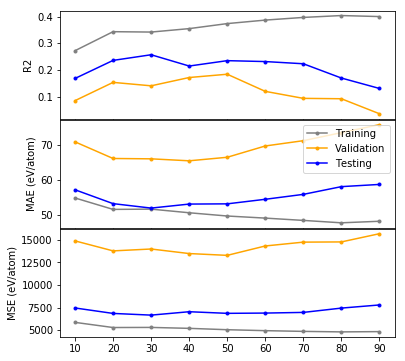

In [127]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.set_ylabel("R2")
ax2.set_ylabel("MAE (eV/atom)")
ax3.set_ylabel("MSE (eV/atom)")

ax1.plot(num_features, score_train['r2_score'], c='grey', marker='.', label='Training')
ax1.plot(num_features, score_val['r2_score'], c='orange', marker='.', label='Validation')
ax1.plot(num_features, score_test['r2_score'], c='blue', marker='.', label='Testing')

ax2.plot(num_features, score_train['mean_absolute_error'], c='grey', marker='.', label='Training')
ax2.plot(num_features, score_val['mean_absolute_error'], c='orange', marker='.', label='Validation')
ax2.plot(num_features, score_test['mean_absolute_error'], c='blue', marker='.', label='Testing')

ax3.plot(num_features, score_train['mean_squared_error'], c='grey', marker='.', label='Training')
ax3.plot(num_features, score_val['mean_squared_error'], c='orange', marker='.', label='Validation')
ax3.plot(num_features, score_test['mean_squared_error'], c='blue', marker='.', label='Testing')

ax2.legend()

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.01)

_Finding_: Using 60 terms is probably sufficient. 
**Prediction is bad. TODO: Obtain total energy data from other sources**

In [129]:
selector = RFE(model, n_features_to_select=60, step=0.9)
selector = selector.fit(x_train, y_train)

In [130]:
cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)

Plot the predictions

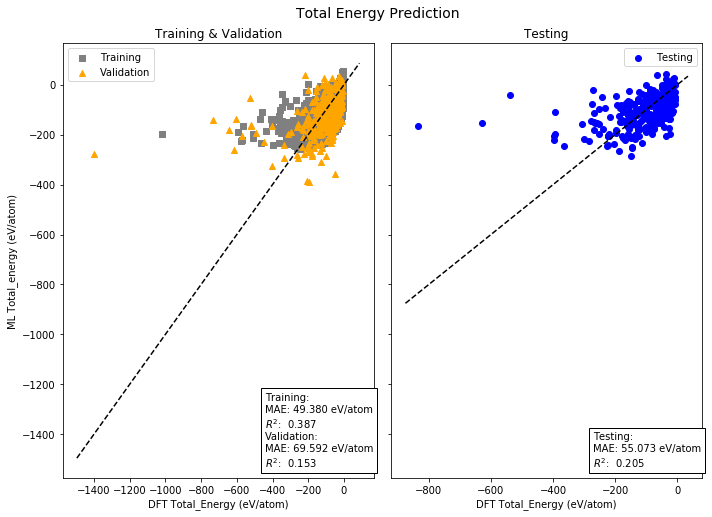

In [131]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Total Energy Prediction', fontsize=14, x=0.53, y=1.02)
# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train)
r2_train = metrics.r2_score(y_train, cv_train)
mae_val = metrics.mean_absolute_error(y_val, cv_val)
r2_val = metrics.r2_score(y_val, cv_val)
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax1.scatter(y_train, cv_train, c='grey', marker='s', label='Training')
ax1.scatter(y_val, cv_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax1.legend()

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT Total_Energy (eV/atom)')
ax1.set_ylabel('ML Total_energy (eV/atom)')

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test)
r2_test = metrics.r2_score(y_test, cv_test)
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.scatter(y_test, cv_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax2.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT Total_Energy (eV/atom)')

fig.set_size_inches(10, 7)
fig.subplots_adjust(hspace=0)
fig.tight_layout()

### Prediction of formation enthalpy

In [132]:
ML_delta_e = pd.Series(index=np.arange(data.shape[0]))

Importing fitted elemental phase reference energies, $\mu^{FERE}$ from `matminer.utils.data_files.deml_elementdata`

In [133]:
from matminer.utils.data_files.deml_elementdata import mus_fere

Using total energy value to compute formation energy according to the equation 
$$\Delta H_f = E_{tot} - \Sigma_i c_i \mu_i^{FERE}$$

In [134]:
for i in range(data.shape[0]):
    fere = (float(data['composition_obj'][i][str(j)])/data['composition_obj'][i].num_atoms*mus_fere[str(j)] for j in (data['composition_obj'][i]))
    fere = sum(fere)
    ML_delta_e[i] = data['total_energy'][i] - fere

Partitioning both ML and DFT formation enthalpy data into training, validation and testing sets.

In [135]:
DFT_delta_e = orig_delta_e
ML_delta_e, DFT_delta_e = shuffle(ML_delta_e, DFT_delta_e)
dft_train, dft_val, dft_test = DFT_delta_e[:int(n*0.7)], DFT_delta_e[int(n*0.7):int(n*0.85)], DFT_delta_e[int(n*0.85):]
ml_train, ml_val, ml_test = ML_delta_e[:int(n*0.7)], ML_delta_e[int(n*0.7):int(n*0.85)], ML_delta_e[int(n*0.85):]

Plot the prediction of formation enthalpy

In [136]:
mae_train = metrics.mean_absolute_error(ml_train, dft_train)
mae_val = metrics.mean_absolute_error(ml_val, dft_val)
mae_test = metrics.mean_absolute_error(ml_test, dft_test)

r2_train = metrics.r2_score(ml_train, dft_train)
r2_val = metrics.r2_score(ml_val, dft_val)
r2_test = metrics.r2_score(ml_test, dft_test)

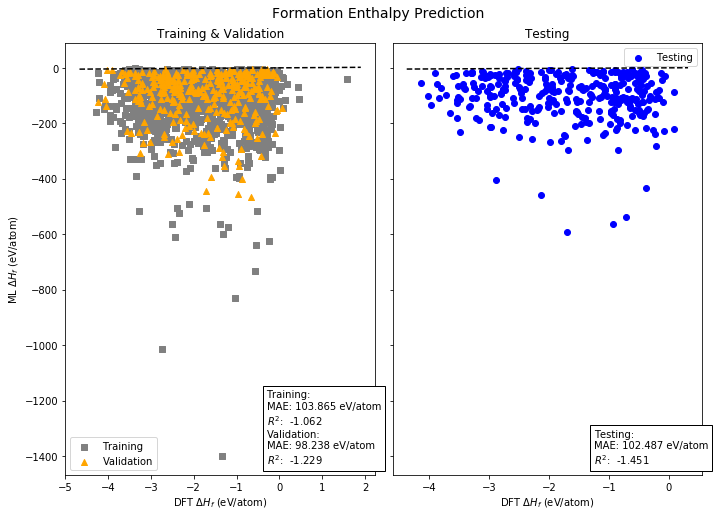

In [137]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Formation Enthalpy Prediction', fontsize=14, x=0.53, y=1.02)

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax1.set_ylabel('ML $\Delta H_f$ (eV/atom)')
ax1.scatter(dft_train, ml_train, c='grey', marker='s', label='Training')
ax1.scatter(dft_val, ml_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax1.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax2.scatter(dft_test, ml_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.legend()

fig.set_size_inches(10, 7)
fig.tight_layout()

***Huge error***. Error mostly comes from ML algorithm underestimating formation enthalpy value.